# Generate Ground Truth with seqFISH+ Data

## Data Importation and Preparation

- **Data Source**: Import datasets from the seqFISH-PLUS GitHub repository containing detailed cell annotations and gene expression data from high-resolution seqFISH+ experiments on the mouse brain.
- **Preparation**: Extract and categorise cells based on type and spatial location. Each cell type's gene expression profile should be catalogued from the high-resolution datasets for reference.

## Simulating Low-Resolution Data

- **Grouping Strategy**: Aggregate cells into larger spatial units ("spots") to simulate lower-resolution imaging. This involves programmatically combining cells from different types in defined spatial areas, maintaining an accurate count of each cell type per spot.
- **Ground Truth Establishment**: Record the exact ratios and types of cells grouped into each spot. This provides the ground truth data against which the performance of deconvolution algorithms can be evaluated.

## Objective of Low-Resolution Simulation

- **Benchmarking Tool**: The primary goal is to use this simulated low-resolution data to test and compare the efficacy of various cellular deconvolution tools. These tools are designed to estimate the composition of cell types within mixed samples, a common challenge in low-resolution datasets.
- **Validation and Comparison**: By comparing the deconvolution outputs against the known ground truth (cell ratios per spot), researchers can assess the accuracy of each tool.

## Output Files

### ground_truth.csv File Structure

This CSV file provides the estimated proportions of various cell types at each bin location. Below is a description of the structure and content of the file:

- **Rows**: Each row corresponds to a specific bin, representing a unique spot on the spatial array. The total number of rows indicates the number of bins analysed, and each row provides the cell type composition for that specific location.
- **Columns**: The columns in this file include a bin_id and several cell types:
  - **bin_id**: This column contains the unique identifiers for each spatial location, correlating to specific spots on the array.
  - **astrocyte**: This column shows the proportion of astrocytes at the corresponding bin location.
  - **endo**: This column shows the proportion of endothelial cells at the corresponding bin location.
  - **eneuron**: This column shows the proportion of excitatory neurons at the corresponding bin location.
  - **ineuron**: This column shows the proportion of interneurons at the corresponding bin location.
  - **microglia**: This column shows the proportion of microglial cells at the corresponding bin location.
  - **olig**: This column shows the proportion of oligodendrocytes at the corresponding bin location.

### sc_counts.csv File Structure

This CSV file presents a comprehensive dataset of gene expression levels measured across individual cells. Here is an outline of the file's dimensions and content:

- **Rows**: Each row in the file represents a single cell. The total number of rows indicates the number of cells analysed in the dataset.
- **Columns**: The first column is reserved for cell_ids, and the subsequent columns represent individual genes:
  - **cell_id**: This column contains unique identifiers for each cell.
  - **Gene columns**: There are 1000 gene columns following the cell_id column. Each column is named after a gene and
   contains numeric values representing the count of transcripts observed for that cell.


### sc_labels.csv File Structure

This CSV file contains identifiers and cell type classifications for individual cells analysed in a dataset. Below is a
description of the structure and content of the file:

- **Rows**: Each row represents a single cell. The total number of rows corresponds to the number of cells included in the analysis.
- **Columns**: There are two columns in this file:
  - **cell_id**: This column contains unique identifiers for each cell.
  - **cell_type**: This column indicates the classified cell type.

### st_coords.csv File Structure

This CSV file provides the spatial coordinates for each bin. Below is a description of the structure and content of the file:

- **Rows**: Each row corresponds to a unique spatial bin. The total number of rows indicates the number of bins analysed.
- **Columns**: There are three columns in this file:
  - **bin_id**: This column contains the unique identifiers for each spot on the spatial array. Each bin is associated with a specific location and potentially multiple captured transcripts.
  - **x**: This column records the x-coordinate, representing the vertical position of each bin.
  - **y**: This column records the y-coordinate, representing the vertical position of each bin.

### st_counts.csv File Structure

This CSV file contains gene expression data captured at each bin location. Below is a description of the structure and content of the file:

- **Rows**: Each row corresponds to a unique bin, which represents a distinct spot on the spatial array. The total number of rows indicates the number of bins, with each row providing the gene expression profile for that specific location.
- **Columns**: The first column is reserved for bin_ids, and the subsequent columns represent individual genes:
  - **bin_id**: This column contains the unique identifiers for each spatial location.
  - **Gene columns**: There are 1000 gene columns following the bin_id column. Each column is named after a gene and contains numeric values representing the count of transcripts observed for that gene at the corresponding bin location.

In [265]:
!pip install pandas
!pip install openpyxl

In [266]:
x_grid = 500
y_grid = 500

# Benchmark paper: 51.5 μm x 51.5 μm = 51500 nm x 51500 nm
# seqFISH+ paper: Coordinates are in units of one pixel (103 nm per pixel). Each camera FOV is 2,000 pixels.
print("Benchmark paper: 51.5 μm x 51.5 μm = 51500 nm x 51500 nm")
print(f"Our approach: {x_grid} pixel x {y_grid} pixel = {x_grid * 103 / 1000} μm x {y_grid * 103 / 1000} μm"
      f" = {x_grid * 103} nm x {y_grid * 103} nm")

Benchmark paper: 51.5 μm x 51.5 μm = 51500 nm x 51500 nm
Our approach: 500 pixel x 500 pixel = 51.5 μm x 51.5 μm = 51500 nm x 51500 nm


In [267]:
import pandas as pd

# Load the data
seqFish_dir = '../data/seqFISH+'
cortex_svz_annot = pd.read_csv(f'{seqFish_dir}/input/cortex_svz_cell_type_annotations.csv')
cortex_svz_coords = pd.read_csv(f'{seqFish_dir}/input/cortex_svz_cellcentroids.csv')
sc_counts = pd.read_csv(f'{seqFish_dir}/input/cortex_svz_counts.csv')
cortex_svz_types = pd.read_excel(f'{seqFish_dir}/input/41586_2019_1049_MOESM3_ESM.xlsx')

In [268]:
def clean_column_names(column):
    """
    Clean column names by stripping whitespace, replacing spaces with underscores,
    and converting to lowercase.
    """
    column = column.strip()
    column = column.replace(' ', '_')
    return column.lower()


# Clean the column names
cortex_svz_annot.columns = [clean_column_names(col) for col in cortex_svz_annot.columns]
cortex_svz_coords.columns = [clean_column_names(col) for col in cortex_svz_coords.columns]
sc_counts.columns = [clean_column_names(col) for col in sc_counts.columns]

In [269]:
assert cortex_svz_annot.shape[0] == cortex_svz_coords.shape[0] == sc_counts.shape[0]
print(f"{sc_counts.shape[0]} cells")
print(f"{sc_counts.shape[1]} genes")
print(f"Regions: {', '.join(cortex_svz_coords['region'].unique().tolist())}")

913 cells
10000 genes
Regions: Cortex, SVZ, Choroid Plexus


In [270]:
# Add cell IDs for sc_counts
sc_counts['cell_id'] = range(1, len(sc_counts) + 1)
column_order = ['cell_id'] + [col for col in sc_counts.columns if col != 'cell_id']
sc_counts = sc_counts[column_order]

In [271]:
# Map the Louvain cluster IDs in the 'louvain' column to their corresponding cell type labels
cell_type_labels = cortex_svz_types.iloc[-1]
label_map = cell_type_labels.to_dict()
cortex_svz_annot['cell_type'] = cortex_svz_annot['louvain'].map(label_map)

In [272]:
cortex_svz_annot

,index,louvain,cell_type
0,0,13,Excitatory layer 3
1,1,3,Excitatory layer II
2,2,3,Excitatory layer II
3,3,7,Interneuron
4,4,6,Excitatory layer 4
...,...,...,...
908,908,1,choroid plexus
909,909,1,choroid plexus
910,910,2,Endothelial
911,911,1,choroid plexus


In [273]:
# Map and update 'cell_type' in cortex_svz_annot based on specified new_labels
new_labels = {
    'Excitatory': 'eneuron',
    'Interneuron': 'ineuron ',
    'Oligodendrocytes': 'olig',
    'Endothelial': 'endo',
    'Astrocytes': 'astrocyte',
    'Microglia': 'microglia',
}

# Mapping of standardised labels to full descriptive names
label_to_full_name = {
    'eneuron': 'Excitatory Neuron',
    'ineuron': 'Interneuron',
    'olig': 'Oligodendrocyte',
    'endo': 'Endothelial Cell',
    'astrocyte': 'Astrocyte',
    'microglia': 'Microglia',
}

# Adding a new column 'benchmark_label' initialised with NaN
cortex_svz_annot['benchmark_label'] = pd.NA

# Map and update the new column 'benchmark_label' based on specified new_labels
for old_label, new_label in new_labels.items():
    mask = cortex_svz_annot['cell_type'].str.contains(old_label)
    cortex_svz_annot.loc[mask, 'benchmark_label'] = new_label

# Drop rows where 'benchmark_label' is NaN
cortex_svz_annot.dropna(subset=['benchmark_label'], inplace=True)
cortex_svz_coords = cortex_svz_coords.loc[cortex_svz_annot.index]
sc_counts = sc_counts.loc[cortex_svz_annot.index]

cortex_svz_annot.head(20)

,index,louvain,cell_type,benchmark_label
0,0,13,Excitatory layer 3,eneuron
1,1,3,Excitatory layer II,eneuron
2,2,3,Excitatory layer II,eneuron
3,3,7,Interneuron,ineuron
4,4,6,Excitatory layer 4,eneuron
5,5,7,Interneuron,ineuron
6,6,3,Excitatory layer II,eneuron
7,7,7,Interneuron,ineuron
8,8,3,Excitatory layer II,eneuron
9,9,3,Excitatory layer II,eneuron


In [274]:
# Find the extreme coordinates for each field of view (FOV)
fov_groups = cortex_svz_coords.groupby('field_of_view')
extreme_coords = {}

for name, group in fov_groups:
    min_x = group['x'].min()
    max_x = group['x'].max()
    min_y = group['y'].min()
    max_y = group['y'].max()
    extreme_coords[name] = {'min_x': min_x, 'max_x': max_x, 'min_y': min_y, 'max_y': max_y}

for fov, coords in extreme_coords.items():
    print(
        f"FOV {fov}: Min X = {coords['min_x']}, Max X = {coords['max_x']}, Min Y = {coords['min_y']}, Max Y = {coords['max_y']}")

FOV 0: Min X = 103.12, Max X = 1960.0, Min Y = 122.03, Max Y = 1777.0
FOV 1: Min X = 176.2, Max X = 1954.9, Min Y = 140.15, Max Y = 1890.9
FOV 2: Min X = 174.8, Max X = 1936.0, Min Y = 154.95, Max Y = 1829.3
FOV 3: Min X = 271.68, Max X = 1909.7, Min Y = 173.2, Max Y = 1832.8
FOV 4: Min X = 197.26, Max X = 1957.4, Min Y = 250.45, Max Y = 1903.3
FOV 5: Min X = 197.86, Max X = 1753.9, Min Y = 175.17, Max Y = 1763.1
FOV 6: Min X = 447.85, Max X = 1755.5, Min Y = 529.93, Max Y = 1672.3


In [275]:
all_bin_edges = []


def assign_spatial_bins(spatial_data, bin_edges):
    """
    Spatially organise cell data into bins based on provided X and Y coordinate edges. 
    """
    # Generate bin edges
    _bin_edges_x = list(range(int(bin_edges['min_x']), int(bin_edges['max_x']) + x_grid, x_grid))
    _bin_edges_y = list(range(int(bin_edges['min_y']), int(bin_edges['max_y']) + y_grid, y_grid))
    _total_num_bins = len(_bin_edges_x) * len(_bin_edges_y)
    all_bin_edges.append((_bin_edges_x, _bin_edges_y))

    # Calculate mid-points for X and Y bins
    mid_points_x = [(edge1 + edge2) / 2 for edge1, edge2 in zip(_bin_edges_x[:-1], _bin_edges_x[1:])]
    mid_points_y = [(edge1 + edge2) / 2 for edge1, edge2 in zip(_bin_edges_y[:-1], _bin_edges_y[1:])]

    # Copy the data to avoid SettingWithCopyWarning
    data = spatial_data.copy()

    # Assign each X and Y to a bin using .loc for explicit indexing
    data.loc[:, 'x_bin'] = pd.cut(data['x'], bins=_bin_edges_x, labels=False)
    data.loc[:, 'y_bin'] = pd.cut(data['y'], bins=_bin_edges_y, labels=False)

    # Create a unique bin ID for each bin combination
    data['bin_id'] = data['x_bin'] + data['y_bin'] * len(_bin_edges_x)

    # Map mid-point coordinates to each row in the dataframe
    data['mid_point_x'] = data['x_bin'].map(lambda _x: mid_points_x[_x])
    data['mid_point_y'] = data['y_bin'].map(lambda _y: mid_points_y[_y])

    return data, _total_num_bins


cell_bins_by_fov = {}

# Assign spatial bins to the data of each FOV
for group_id, group_data in fov_groups:
    cell_bins_by_fov[group_id], total_num_bins = assign_spatial_bins(group_data, extreme_coords[group_id])

    filled_bins = cell_bins_by_fov[group_id]['bin_id'].nunique()
    cell_count = cell_bins_by_fov[group_id].shape[0]
    avg_density = cell_count / total_num_bins

    print(f"FOV {group_id} ({cell_bins_by_fov[group_id]['region'].iloc[1]})")
    print(f"{filled_bins} bins filled out of {total_num_bins} total")
    print(f"Cell count: {cell_count}")
    print(f"Avg. cell density: {avg_density:.2f} cells per bin")
    print(f"Avg. cell density per filled bin: {cell_count / filled_bins:.2f} cells per bin\n")

FOV 0 (Cortex)
16 bins filled out of 25 total
Cell count: 115
Avg. cell density: 4.60 cells per bin
Avg. cell density per filled bin: 7.19 cells per bin

FOV 1 (Cortex)
14 bins filled out of 25 total
Cell count: 106
Avg. cell density: 4.24 cells per bin
Avg. cell density per filled bin: 7.57 cells per bin

FOV 2 (Cortex)
15 bins filled out of 25 total
Cell count: 79
Avg. cell density: 3.16 cells per bin
Avg. cell density per filled bin: 5.27 cells per bin

FOV 3 (Cortex)
15 bins filled out of 25 total
Cell count: 104
Avg. cell density: 4.16 cells per bin
Avg. cell density per filled bin: 6.93 cells per bin

FOV 4 (Cortex)
14 bins filled out of 25 total
Cell count: 93
Avg. cell density: 3.72 cells per bin
Avg. cell density per filled bin: 6.64 cells per bin

FOV 5 (SVZ)
12 bins filled out of 25 total
Cell count: 64
Avg. cell density: 2.56 cells per bin
Avg. cell density per filled bin: 5.33 cells per bin

FOV 6 (Choroid Plexus)
8 bins filled out of 16 total
Cell count: 15
Avg. cell dens

In [276]:
import numpy as np

# Map each local bin ID to a unique global bin ID.
global_bin_id = 0
total_num_bins = 0
for fov, cell_data in cell_bins_by_fov.items():
    unique_bin_ids = cell_data['bin_id'].unique().tolist()
    unique_bin_ids.sort()
    total_num_bins += len(unique_bin_ids)

    for bin_id in unique_bin_ids:
        cell_bins_by_fov[fov].loc[cell_data['bin_id'] == bin_id, 'global_bin_id'] = global_bin_id
        global_bin_id += 1

    cell_data['global_bin_id'] = cell_data['global_bin_id'].astype(np.int64)

cell_data = pd.concat(cell_bins_by_fov.values())
cell_data = pd.merge(cell_data, cortex_svz_annot, left_index=True, right_index=True, how='inner')
print(f"Total number of bins: {total_num_bins}")
assert cell_data['global_bin_id'].nunique() == total_num_bins

# Add cell IDs for cell_data
cell_data['cell_id'] = range(0, len(cell_data))
column_order = ['cell_id'] + [col for col in cell_data.columns if col != 'cell_id']
cell_data = cell_data[column_order]

cell_data.head()

Total number of bins: 94


,cell_id,field_of_view,x,y,region,x_bin,y_bin,bin_id,mid_point_x,mid_point_y,global_bin_id,index,louvain,cell_type,benchmark_label
0,0,0,1305.70,414.98,Cortex,2,0,2,1353.0,372.0,2,0,13,Excitatory layer 3,eneuron
1,1,0,669.51,457.53,Cortex,1,0,1,853.0,372.0,1,1,3,Excitatory layer II,eneuron
2,2,0,1185.90,507.11,Cortex,2,0,2,1353.0,372.0,2,2,3,Excitatory layer II,eneuron
3,3,0,710.24,533.06,Cortex,1,0,1,853.0,372.0,1,3,7,Interneuron,ineuron
4,4,0,763.87,569.15,Cortex,1,0,1,853.0,372.0,1,4,6,Excitatory layer 4,eneuron


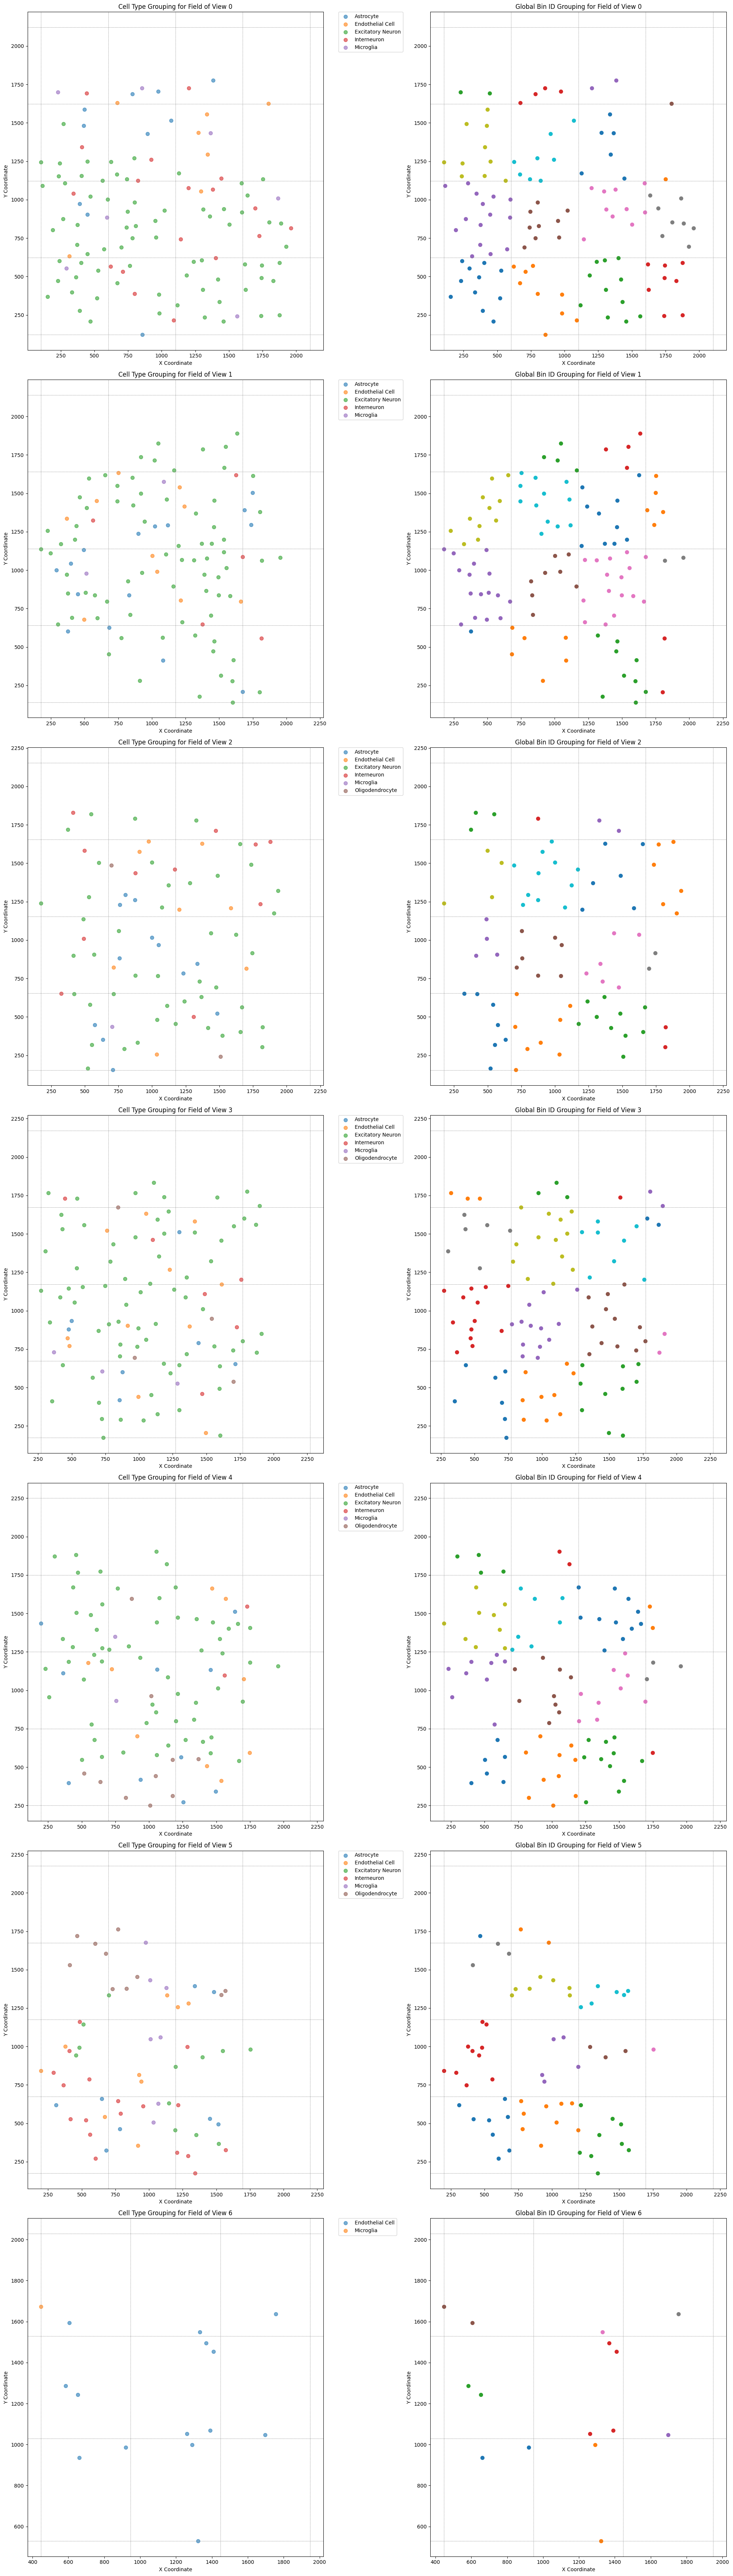

In [277]:
import matplotlib.pyplot as plt

num_fovs = len(cell_data['field_of_view'].unique())
fig, axes = plt.subplots(nrows=num_fovs, ncols=2, figsize=(20, 10 * num_fovs))

for i, (fov_name, group) in enumerate(cell_data.groupby('field_of_view')):
    ax1, ax2 = axes[i]

    # Plot setup for the first subplot
    ax1.set_title(f'Cell Type Grouping for Field of View {fov_name}')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')

    # Group by cell type and plot
    for label, label_group in group.groupby('benchmark_label'):
        full_name = label_to_full_name.get(label.strip(), label)
        ax1.scatter(label_group['x'], label_group['y'], label=full_name, s=50, alpha=0.6)

    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # Group by Global_Bin_ID for the second subplot
    ax2.set_title(f'Global Bin ID Grouping for Field of View {fov_name}')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')

    # Plot each group with distinct colors
    for bin_id, bin_group in group.groupby('global_bin_id'):
        ax2.scatter(bin_group['x'], bin_group['y'], label=f'Bin {bin_id}', s=50)

        # Extract and plot only one midpoint per bin group
        midpoint_x = bin_group['mid_point_x'].iloc[0]
        midpoint_y = bin_group['mid_point_y'].iloc[0]
        # ax2.scatter(midpoint_x, midpoint_y, color='red', marker='x', s=50, alpha=0.5)

    # Draw bin edges on the first subplot
    bin_edges_x, bin_edges_y = all_bin_edges[i]
    for x in bin_edges_x:
        ax1.axvline(x, color='grey', linestyle='--', linewidth=0.5)
        ax2.axvline(x, color='grey', linestyle='--', linewidth=0.5)
    for y in bin_edges_y:
        ax1.axhline(y, color='grey', linestyle='--', linewidth=0.5)
        ax2.axhline(y, color='grey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

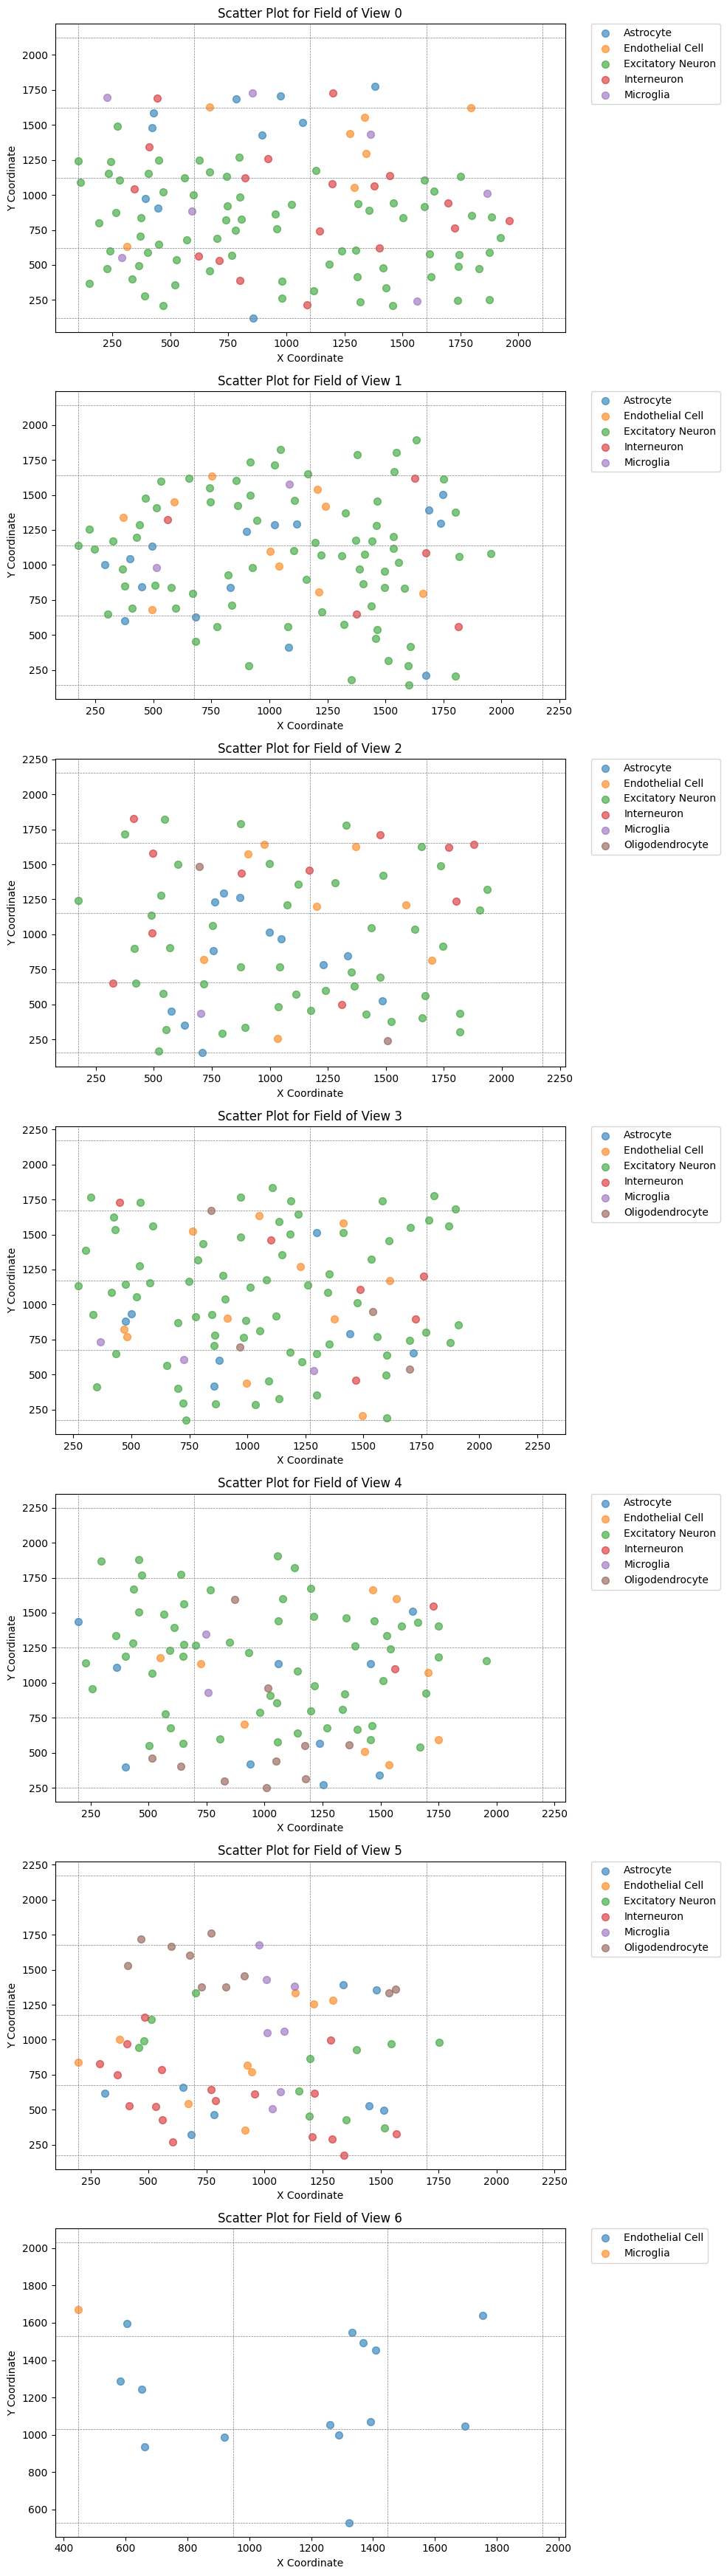

In [278]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 35))

# Loop over each field of view
for i, (name, group) in enumerate(cell_data.groupby('field_of_view')):
    ax = axes[i]
    ax.set_title(f'Scatter Plot for Field of View {name}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # Draw bin edges
    bin_edges_x, bin_edges_y = all_bin_edges[i]
    for x in bin_edges_x:
        ax.axvline(x, color='grey', linestyle='--', linewidth=0.5)
    for y in bin_edges_y:
        ax.axhline(y, color='grey', linestyle='--', linewidth=0.5)

    # Group by cell type within each field of view
    benchmark_groups = group.groupby('benchmark_label')
    for label, label_group in benchmark_groups:
        full_name = label_to_full_name.get(label.strip(), label)
        ax.scatter(label_group['x'], label_group['y'], label=full_name, s=50, alpha=0.6)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    # ax.grid(True)

plt.tight_layout()
plt.show()

In [279]:
# Aggregate the counts for each gene across all cells in each bin
st_counts = cell_data.sort_values('global_bin_id')
st_counts = sc_counts.groupby(st_counts['global_bin_id']).apply(lambda idx: idx.sum())
st_counts.drop(columns=['cell_id'], inplace=True)
st_counts = st_counts.sort_index()

print(f"Number of bins: {st_counts.shape[0]}")
print(f"Number of genes: {st_counts.shape[1]}")

Number of bins: 94
Number of genes: 10000


In [280]:
# Calculate cell ratios for each bin
label_counts = cell_data.groupby(['global_bin_id', 'benchmark_label']).size().unstack(fill_value=0)

# Calculating the ratio of each benchmark_label within each global_bin_id
ground_truth = label_counts.div(label_counts.sum(axis=1), axis=0)
ground_truth.columns.name = None
ground_truth.index.name = 'bin_id'

In [281]:
# Get exact coordinates of each bin
st_coords = cell_data.drop_duplicates(subset=['global_bin_id'])

# Keep only the necessary columns
st_coords = st_coords[['global_bin_id', 'mid_point_x', 'mid_point_y']]

# Rename 'mid_point_x' and 'mid_point_y' to 'x' and 'y'
st_coords.rename(columns={'mid_point_x': 'x', 'mid_point_y': 'y'}, inplace=True)

# Order st_coords by global_bin_id
st_coords = st_coords.sort_values('global_bin_id')

# Convert 'x' and 'y' columns to integers
st_coords['x'] = st_coords['x'].astype(int)
st_coords['y'] = st_coords['y'].astype(int)

In [282]:
sc_labels = cell_data[['cell_id', 'benchmark_label']].copy()

# Rename 'benchmark_label' to 'cell_type'
sc_labels.rename(columns={'benchmark_label': 'cell_type'}, inplace=True)

# Rename 'global_bin_id' to 'bin_id'
st_coords.rename(columns={'global_bin_id': 'bin_id'}, inplace=True)
st_counts.index.name = 'bin_id'

In [283]:
# Export the ground_truth to a CSV file
ground_truth.to_csv(f'{seqFish_dir}/ground_truth.csv', index=True, header=True)

# Export the sc_counts to a CSV file
sc_counts.to_csv(f'{seqFish_dir}/sc_counts.csv', index=False, header=True)

# Export the sc_labels to a CSV file
sc_labels.to_csv(f'{seqFish_dir}/sc_labels.csv', index=False, header=True)

# Export the st_coords to a CSV file
st_coords.to_csv(f'{seqFish_dir}/st_coords.csv', index=False, header=True)

# Export the st_counts to a CSV file
st_counts.to_csv(f'{seqFish_dir}/st_counts.csv', index=True, header=True)